# Latency Comparison

In this section we collect results from measuring the latency between ingesting data from the source and collecting the data from the broker (i.e., Kafka vs NGSI-LD Broker).

First, execute the tests from Apache NiFi for each number of events to be sent to the broker every second. The results from these tests will be stored in `results/latency/<broker>/`.

## Building the Datasets

In [1]:
import pandas as pd

#Disable scientific notation in datasets
pd.set_option('display.float_format', lambda x: '%.4f' % x)

Set list with number events per second configured for each experiment.

In [2]:
events = [50,100,200,500,1000]

### Scorpio

In [3]:
import glob

scorpio = []
for event in events:
    path = r'./results/latency/scorpio/%s' % event # use your path
    all_files = glob.glob(path + "/*")

    li = []

    for filename in all_files:
        df = pd.read_csv(filename, index_col=None, header=0)
        li.append(df)

    scorpio.append(pd.concat(li, axis=0, ignore_index=True))
    
# Estimate the delta between the collection and notification timestamps
scorpio_means = []
for table in scorpio:
    table["deltaTimestamp"] = table["notificationTimestamp"] - table["collectionTimestamp"]
    scorpio_means.append(table["deltaTimestamp"].mean())

### Orion-LD

In [4]:
import glob

orion = []
for event in events:
    path = r'./results/latency/fiware-orion/%s' % event # use your path
    all_files = glob.glob(path + "/*")

    li = []

    for filename in all_files:
        df = pd.read_csv(filename, index_col=None, header=0)
        li.append(df)

    orion.append(pd.concat(li, axis=0, ignore_index=True))
    
# Estimate the delta between the collection and notification timestamps
orion_means = []
for table in orion:
    table["deltaTimestamp"] = table["notificationTimestamp"] - table["collectionTimestamp"]
    orion_means.append(table["deltaTimestamp"].mean())

### Kafka-AVRO

In [5]:
import glob

kafka_avro = []
for event in events:
    path = r'./results/latency/kafka-avro/%s' % event # use your path
    all_files = glob.glob(path + "/*")

    li = []

    for filename in all_files:
        df = pd.read_csv(filename, index_col=None, header=0)
        li.append(df)

    kafka_avro.append(pd.concat(li, axis=0, ignore_index=True))

# Estimate the delta between the collection and notification timestamps
kafka_avro_means = []
for table in kafka_avro:
    table["deltaTimestamp"] = table["notificationTimestamp"] - table["collectionTimestamp"]
    kafka_avro_means.append(table["deltaTimestamp"].mean())

### Kafka-NGSI-LD

In [49]:
import glob

kafka_ngsi_ld = []
for event in events:
    path = r'./results/latency/kafka-ngsi-ld/%s' % event # use your path
    all_files = glob.glob(path + "/*")

    li = []

    for filename in all_files:
        df = pd.read_csv(filename, index_col=None, header=0)
        li.append(df)

    kafka_ngsi_ld.append(pd.concat(li, axis=0, ignore_index=True))

# Estimate the delta between the collection and notification timestamps
kafka_ngsi_ld_means = []
for table in kafka_ngsi_ld:
    table["deltaTimestamp"] = table["notificationTimestamp"] - table["collectionTimestamp"]
    kafka_ngsi_ld_means.append(table["deltaTimestamp"].mean())

## Visualization

Once the datasets haven prepared, move on to creating some plots.

In [59]:
import matplotlib.pyplot as plt
from matplotlib import cm
plt.close("all")


,Events,Kafka-AVRO
0,50,572.1868
1,100,586.1209
2,200,581.9034
3,500,631.6066
4,1000,748.6454


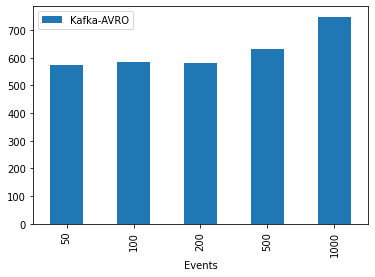

In [51]:
latency = pd.DataFrame({"Events": events,
                       "Kafka-AVRO": kafka_avro_means})
latency.plot.bar(x="Events", logy=False)
latency

,Events,Orion-LD,Scorpio,Kafka-AVRO,Kafka-NGSI-LD
0,50,128.1170,206.5638,572.1868,537.4713
1,100,173.6202,281.5921,586.1209,540.7738
2,200,295.0969,13485.0493,581.9034,541.9778
3,500,31410.0055,54216.9112,631.6066,578.0237
4,1000,45293.2354,34524.3336,748.6454,639.1002


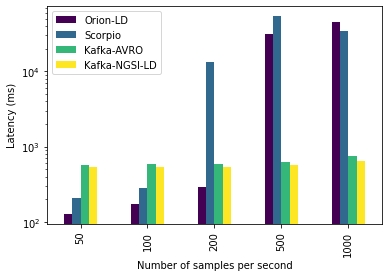

In [60]:
latency = pd.DataFrame({"Events": events,"Orion-LD": orion_means,
                       "Scorpio": scorpio_means, 
                       "Kafka-AVRO": kafka_avro_means,
                       "Kafka-NGSI-LD": kafka_ngsi_ld_means})
#colors = ['tab:blue','tab:orange', "tab:green", "tab:red"]
colors=cm.get_cmap('viridis', 4).colors
latency_plot = latency.plot.bar(x="Events", logy=True, color=colors)
latency_plot.set_xlabel("Number of samples per second")
latency_plot.set_ylabel("Latency (ms)")
latency

Text(0, 0.5, 'Latency (ms)')

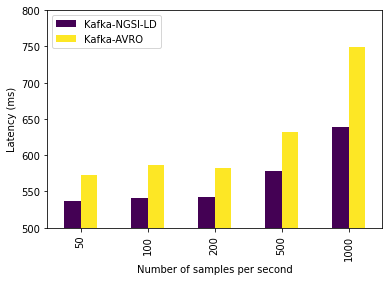

In [63]:
latency_kafka = pd.DataFrame({"Events": events,
                              "Kafka-NGSI-LD": kafka_ngsi_ld_means, 
                              "Kafka-AVRO": kafka_avro_means })
#colors = ['tab:red','tab:green']
colors=cm.get_cmap('viridis', 2).colors
latency_kafka_plot = latency_kafka.plot.bar(x="Events", ylim=(500,800), color=colors)
latency_kafka_plot.set_xlabel("Number of samples per second")
latency_kafka_plot.set_ylabel("Latency (ms)")

# Container Performance

The following snippet produces docker stats and appends the results to a CSV file. For these validation tests, we collect the memory and CPU percentage usage:

```bash
while true; do docker stats <my_container> --no-stream --format "{{ .Name }},{{ .CPUPerc }},{{ .MemPerc }}" | tee --append results/cpu_memory/<my_container>/<my_container>_<events>.csv; sleep 1; done
```

The following example collects CPU and memory percentage usage stats for the services dependent on the Orion-LD broker when 50 events are sent every second.
```bash
while true; do docker stats db-mongo fiware-orion nifi --no-stream --format "{{ .Name }},{{ .CPUPerc }},{{ .MemPerc }}" | tee --append results/cpu_memory/orion/orion_50.csv; sleep 1; done
```

We collect results for each NGSI-LD Broker and for Kafka while running the latency tests. Make sure to specify the `events` value used for the latency tests.

You can also use the `collect_docker_stats.sh` utility. The following example collects CPU and memory percentage usage stats for kafka when 60 events are sent every second:

```bash
./collect_docker_stats.sh kafka 60
```

## Building the Datasets

Process the generated CSV files using panda. First remove the percentage character from the memory and CPU columns. Then generate two charts - memory and CPU - that compare Kafka container against each NGSI-LD Broker container.

### Scorpio

In [11]:
scorpio_services = []
for event in events:
    dataset_path = r'./results/cpu_memory/scorpio/scorpio_%s.csv' % event # use your path    
    table = pd.read_csv(dataset_path, index_col=0, 
                        header=0, names=["service", "cpu", "memory"])
    table['cpu'] = table['cpu'].str.rstrip('%').astype('float') / 100.0
    table['memory'] = table['memory'].str.rstrip('%').astype('float') / 100.0
    scorpio_services.append(table)

In [12]:
scorpio_cpu = {}
for table in scorpio_services:
    cpu_means = table.groupby("service").mean()["cpu"]
    for index,value in cpu_means.iteritems():
        if index == "nifi":
            continue
        if index not in scorpio_cpu:
            scorpio_cpu[index] = []
        scorpio_cpu[index].append(value)

,kafka,postgres,scorpio
50,0.1946,0.1400,0.7166
100,0.2986,0.2772,1.1851
200,0.4189,0.4618,2.1870
500,0.4078,0.2780,1.9761
1000,0.2665,0.2347,1.2327


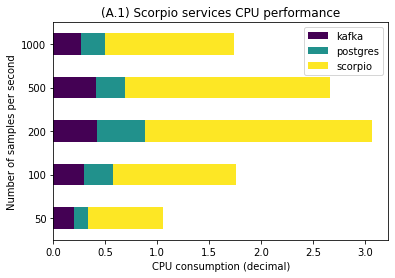

In [64]:
scorpio_cpu_df = pd.DataFrame(scorpio_cpu, index=events)
#colors = ['tab:olive','tab:cyan', "tab:orange"]
colors=cm.get_cmap('viridis', 3).colors
scorpio_cpu_df_plot = scorpio_cpu_df.plot.barh(stacked=True, color=colors,
                                                          title="(A.1) Scorpio services CPU performance")
scorpio_cpu_df_plot.set_xlabel("CPU consumption (decimal)")
scorpio_cpu_df_plot.set_ylabel("Number of samples per second")

scorpio_cpu_df

In [14]:
scorpio_cpu_total = []
for i in range(0,len(events)):
    scorpio_cpu_total.append(scorpio_cpu['kafka'][i]+scorpio_cpu['postgres'][i]+scorpio_cpu['scorpio'][i])

In [15]:
scorpio_mem = {}
for table in scorpio_services:
    mem_means = table.groupby("service").mean()["memory"]
    for index,value in mem_means.iteritems():
        if index == "nifi":
            continue
        if index not in scorpio_mem:
            scorpio_mem[index] = []
        scorpio_mem[index].append(value)

,kafka,postgres,scorpio
50,0.0381,0.0114,0.2088
100,0.0665,0.0165,0.2100
200,0.0751,0.0210,0.2105
500,0.0370,0.0119,0.2171
1000,0.0521,0.0155,0.2320


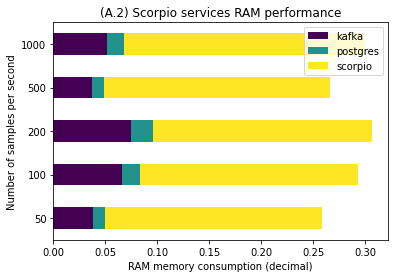

In [65]:
scorpio_mem_df = pd.DataFrame(scorpio_mem, index=events)
#colors = ['tab:olive','tab:cyan', "tab:orange"]
colors=cm.get_cmap('viridis', 3).colors
scorpio_mem_df_plot = scorpio_mem_df.plot.barh(stacked=True, color=colors,
                                                          title="(A.2) Scorpio services RAM performance")
scorpio_mem_df_plot.set_xlabel("RAM memory consumption (decimal)")
scorpio_mem_df_plot.set_ylabel("Number of samples per second")

scorpio_mem_df

In [17]:
scorpio_mem_total = []
for i in range(0,len(events)):
    scorpio_mem_total.append(scorpio_mem['kafka'][i]+scorpio_mem['postgres'][i]+scorpio_mem['scorpio'][i])

### Orion-LD

In [18]:
orion_services = []
for event in events:
    dataset_path = r'./results/cpu_memory/orion/orion_%s.csv' % event # use your path    
    table = pd.read_csv(dataset_path, index_col=0, 
                        header=0, names=["service", "cpu", "memory"])
    table['cpu'] = table['cpu'].str.rstrip('%').astype('float') / 100.0
    table['memory'] = table['memory'].str.rstrip('%').astype('float') / 100.0
    orion_services.append(table)

In [19]:
orion_cpu = {}
for table in orion_services:
    cpu_means = table.groupby("service").mean()["cpu"]
    for index,value in cpu_means.iteritems():
        if index == "nifi":
            continue
        if index not in orion_cpu:
            orion_cpu[index] = []
        orion_cpu[index].append(value)

,mongo-db,orion-ld
50,0.0434,0.1539
100,0.0584,0.2203
200,0.1382,0.5369
500,0.1567,0.7279
1000,0.0940,0.3347


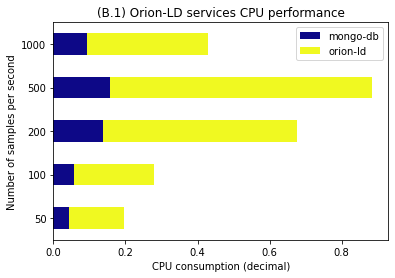

In [68]:
#colors = ['lightcoral','tab:blue']
colors=cm.get_cmap('plasma', 2).colors
orion_cpu_df = pd.DataFrame(orion_cpu, index=events)
orion_cpu_df_plot = orion_cpu_df.plot.barh(stacked=True, color=colors,
                                                          title="(B.1) Orion-LD services CPU performance")
orion_cpu_df_plot.set_xlabel("CPU consumption (decimal)")
orion_cpu_df_plot.set_ylabel("Number of samples per second")

orion_cpu_df

In [21]:
orion_cpu_total = []
for i in range(0,len(events)):
    orion_cpu_total.append(orion_cpu['mongo-db'][i]+orion_cpu['orion-ld'][i])

In [22]:
orion_mem = {}
for table in orion_services:
    mem_means = table.groupby("service").mean()["memory"]
    for index,value in mem_means.iteritems():
        if index == "nifi":
            continue
        if index not in orion_mem:
            orion_mem[index] = []
        orion_mem[index].append(value)

,mongo-db,orion-ld
50,0.0030,0.0016
100,0.0031,0.0009
200,0.0030,0.0012
500,0.0030,0.0014
1000,0.0027,0.0008


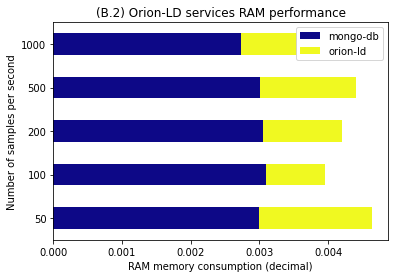

In [69]:
#colors = ['lightcoral','tab:blue']
colors=cm.get_cmap('plasma', 2).colors
orion_mem_df = pd.DataFrame(orion_mem, index=events)
orion_mem_df_plot = orion_mem_df.plot.barh(stacked=True, color=colors,
                                                          title="(B.2) Orion-LD services RAM performance")
orion_mem_df_plot.set_xlabel("RAM memory consumption (decimal)")
orion_mem_df_plot.set_ylabel("Number of samples per second")

orion_mem_df

In [24]:
orion_mem_total = []
for i in range(0,len(orion_mem[index])):
    orion_mem_total.append(orion_mem['mongo-db'][i]+orion_mem['orion-ld'][i])

### Kafka-AVRO

In [25]:
kafka_avro_services = []
for event in events:
    dataset_path = r'./results/cpu_memory/kafka-avro/kafka-avro_%s.csv' % event # use your path    
    table = pd.read_csv(dataset_path, index_col=0, 
                        header=0, names=["service", "cpu", "memory"])
    table['cpu'] = table['cpu'].str.rstrip('%').astype('float') / 100.0
    table['memory'] = table['memory'].str.rstrip('%').astype('float') / 100.0
    kafka_avro_services.append(table)

In [26]:
kafka_avro_cpu = {}
for table in kafka_avro_services:
    cpu_means = table.groupby("service").mean()["cpu"]
    for index,value in cpu_means.iteritems():
        if index == "nifi":
            continue
        if index not in kafka_avro_cpu:
            kafka_avro_cpu[index] = []
        kafka_avro_cpu[index].append(value)

,kafka
50,0.0701
100,0.1164
200,0.1325
500,0.1104
1000,0.1366


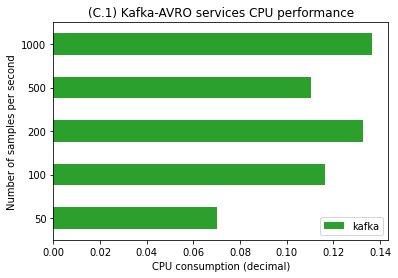

In [27]:
colors = ['tab:green']
kafka_avro_cpu_df = pd.DataFrame(kafka_avro_cpu, index=events)
kafka_avro_cpu_df_plot = kafka_avro_cpu_df.plot.barh(stacked=True, color=colors,
                                                          title="(C.1) Kafka-AVRO services CPU performance")
kafka_avro_cpu_df_plot.set_xlabel("CPU consumption (decimal)")
kafka_avro_cpu_df_plot.set_ylabel("Number of samples per second")

kafka_avro_cpu_df

In [28]:
kafka_avro_cpu_total = []
for i in range(0,len(events)):
    kafka_avro_cpu_total.append(kafka_avro_cpu['kafka'][i])

In [29]:
kafka_avro_mem = {}
for table in kafka_avro_services:
    mem_means = table.groupby("service").mean()["memory"]
    for index,value in mem_means.iteritems():
        if index == "nifi":
            continue
        if index not in kafka_avro_mem:
            kafka_avro_mem[index] = []
        kafka_avro_mem[index].append(value)

,kafka
50,0.0234
100,0.0265
200,0.0371
500,0.0517
1000,0.0584


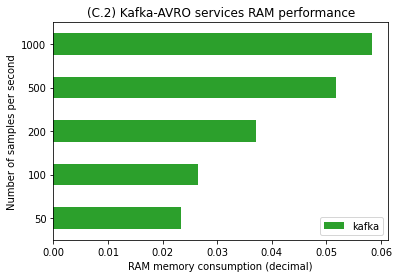

In [30]:
colors = ['tab:green']
kafka_avro_mem_df = pd.DataFrame(kafka_avro_mem, index=events)
kafka_avro_mem_df_plot = kafka_avro_mem_df.plot.barh(stacked=True, color=colors,
                                                          title="(C.2) Kafka-AVRO services RAM performance")
kafka_avro_mem_df_plot.set_xlabel("RAM memory consumption (decimal)")
kafka_avro_mem_df_plot.set_ylabel("Number of samples per second")

kafka_avro_mem_df

In [31]:
kafka_avro_mem_total = []
for i in range(0,len(events)):
    kafka_avro_mem_total.append(kafka_avro_mem['kafka'][i])

### Kafka-NGSI-LD

In [32]:
kafka_ngsi_ld_services = []
for event in events:
    dataset_path = r'./results/cpu_memory/kafka-ngsi-ld/kafka-ngsi-ld_%s.csv' % event # use your path    
    table = pd.read_csv(dataset_path, index_col=0, 
                        header=0, names=["service", "cpu", "memory"])
    table['cpu'] = table['cpu'].str.rstrip('%').astype('float') / 100.0
    table['memory'] = table['memory'].str.rstrip('%').astype('float') / 100.0
    kafka_ngsi_ld_services.append(table)

In [33]:
kafka_ngsi_ld_cpu = {}
for table in kafka_ngsi_ld_services:
    cpu_means = table.groupby("service").mean()["cpu"]
    for index,value in cpu_means.iteritems():
        if index == "nifi":
            continue
        if index not in kafka_ngsi_ld_cpu:
            kafka_ngsi_ld_cpu[index] = []
        kafka_ngsi_ld_cpu[index].append(value)

,kafka
50,0.0815
100,0.0541
200,0.0639
500,0.1078
1000,0.0977


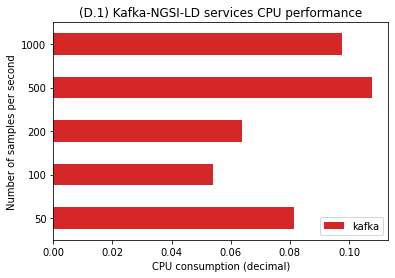

In [34]:
colors = ['tab:red']
kafka_ngsi_ld_cpu_df = pd.DataFrame(kafka_ngsi_ld_cpu, index=events)
kafka_ngsi_ld_cpu_df_plot = kafka_ngsi_ld_cpu_df.plot.barh(stacked=True, color=colors, 
                                                           title="(D.1) Kafka-NGSI-LD services CPU performance")
kafka_ngsi_ld_cpu_df_plot.set_xlabel("CPU consumption (decimal)")
kafka_ngsi_ld_cpu_df_plot.set_ylabel("Number of samples per second")

kafka_ngsi_ld_cpu_df

In [35]:
kafka_ngsi_ld_cpu_total = []
for i in range(0,len(events)):
    kafka_ngsi_ld_cpu_total.append(kafka_ngsi_ld_cpu['kafka'][i])

In [36]:
kafka_ngsi_ld_mem = {}
for table in kafka_ngsi_ld_services:
    mem_means = table.groupby("service").mean()["memory"]
    for index,value in mem_means.iteritems():
        if index == "nifi":
            continue
        if index not in kafka_ngsi_ld_mem:
            kafka_ngsi_ld_mem[index] = []
        kafka_ngsi_ld_mem[index].append(value)

,kafka
50,0.0245
100,0.0657
200,0.0636
500,0.0644
1000,0.0653


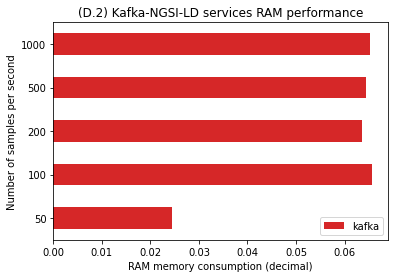

In [37]:
colors = ['tab:red']
kafka_ngsi_ld_mem_df = pd.DataFrame(kafka_ngsi_ld_mem, index=events)
kafka_ngsi_ld_mem_df_plot = kafka_ngsi_ld_mem_df.plot.barh(stacked=True, color=colors,
                                                          title="(D.2) Kafka-NGSI-LD services RAM performance")
kafka_ngsi_ld_mem_df_plot.set_xlabel("RAM memory consumption (decimal)")
kafka_ngsi_ld_mem_df_plot.set_ylabel("Number of samples per second")

kafka_ngsi_ld_mem_df

In [38]:
kafka_ngsi_ld_mem_total = []
for i in range(0,len(events)):
    kafka_ngsi_ld_mem_total.append(kafka_ngsi_ld_mem['kafka'][i])

## CPU and RAM memory comparison

Building some charts to compare the results of CPU and RAM consumption between the NGSI-LD Brokers and Kafka use cases.

,Orion-LD,Scorpio
50,0.1973,1.0511
100,0.2786,1.7609
200,0.6751,3.0678
500,0.8846,2.6619
1000,0.4287,1.7339


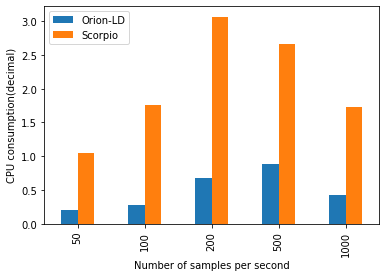

In [39]:
cpu = pd.DataFrame({"Orion-LD": orion_cpu_total,
                       "Scorpio": scorpio_cpu_total}, index=events)
colors = ['tab:blue','tab:orange']
cpu_plot = cpu.plot.bar(logy=False, color=colors)
cpu_plot.set_xlabel("Number of samples per second")
cpu_plot.set_ylabel("CPU consumption(decimal)")

cpu

,Orion-LD,Scorpio,Kafka-AVRO,Kafka-NGSI-LD
50,0.1973,1.0511,0.0701,0.0815
100,0.2786,1.7609,0.1164,0.0541
200,0.6751,3.0678,0.1325,0.0639
500,0.8846,2.6619,0.1104,0.1078
1000,0.4287,1.7339,0.1366,0.0977


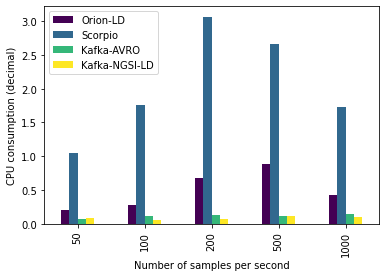

In [70]:
cpu = pd.DataFrame({"Orion-LD": orion_cpu_total,
                    "Scorpio": scorpio_cpu_total,
                    "Kafka-AVRO": kafka_avro_cpu_total,
                    "Kafka-NGSI-LD": kafka_ngsi_ld_cpu_total}, index=events)
#colors = ['tab:blue','tab:orange', "tab:green", "tab:red"]
colors=cm.get_cmap('viridis', 4).colors
cpu_plot = cpu.plot.bar(logy=False, color=colors)
cpu_plot.set_xlabel("Number of samples per second")
cpu_plot.set_ylabel("CPU consumption (decimal)")

cpu

,Orion-LD,Scorpio,Kafka-AVRO,Kafka-NGSI-LD
50,0.1973,1.0511,0.0701,0.0815
100,0.2786,1.7609,0.1164,0.0541
200,0.6751,3.0678,0.1325,0.0639


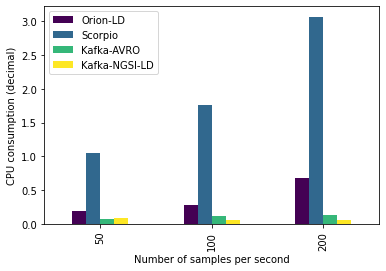

In [77]:
cpu = pd.DataFrame({"Orion-LD": orion_cpu_total,
                    "Scorpio": scorpio_cpu_total,
                    "Kafka-AVRO": kafka_avro_cpu_total,
                    "Kafka-NGSI-LD": kafka_ngsi_ld_cpu_total}, index=events)
#colors = ['tab:blue','tab:orange', "tab:green", "tab:red"]
colors=cm.get_cmap('viridis', 4).colors
cpu_plot = cpu.iloc[[0,1,2]].plot.bar(logy=False, color=colors)
cpu_plot.set_xlabel("Number of samples per second")
cpu_plot.set_ylabel("CPU consumption (decimal)")

cpu.iloc[[0,1,2]]

,Orion-LD,Scorpio,Kafka-AVRO,Kafka-NGSI-LD
200,0.6751,3.0678,0.1325,0.0639


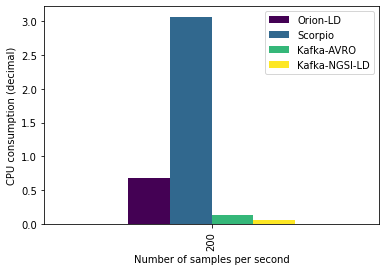

In [76]:
cpu = pd.DataFrame({"Orion-LD": orion_cpu_total,
                    "Scorpio": scorpio_cpu_total,
                    "Kafka-AVRO": kafka_avro_cpu_total,
                    "Kafka-NGSI-LD": kafka_ngsi_ld_cpu_total}, index=events)
#colors = ['tab:blue','tab:orange', "tab:green", "tab:red"]
colors=cm.get_cmap('viridis', 4).colors
cpu_plot = cpu.iloc[[2]].plot.bar(logy=False, color=colors)
cpu_plot.set_xlabel("Number of samples per second")
cpu_plot.set_ylabel("CPU consumption (decimal)")

cpu.iloc[[2]]

,Orion-LD,Scorpio,Kafka-AVRO,Kafka-NGSI-LD
50,0.0046,0.2583,0.0234,0.0245
100,0.0040,0.2930,0.0265,0.0657
200,0.0042,0.3067,0.0371,0.0636
500,0.0044,0.2660,0.0517,0.0644
1000,0.0035,0.2996,0.0584,0.0653


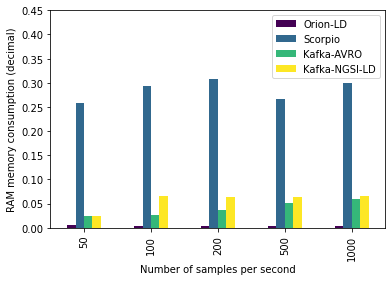

In [75]:
mem = pd.DataFrame({"Orion-LD": orion_mem_total,
                    "Scorpio": scorpio_mem_total,
                    "Kafka-AVRO": kafka_avro_mem_total,
                    "Kafka-NGSI-LD": kafka_ngsi_ld_mem_total}, index=events)
#colors = ['tab:blue','tab:orange', "tab:green", "tab:red"]
colors=cm.get_cmap('viridis', 4).colors
mem_plot = mem.plot.bar(logy=False, ylim=(0,0.45), color=colors)
mem_plot.set_xlabel("Number of samples per second")
mem_plot.set_ylabel("RAM memory consumption (decimal)")

mem

,Orion-LD,Scorpio,Kafka-AVRO,Kafka-NGSI-LD
50,0.0046,0.2583,0.0234,0.0245
100,0.0040,0.2930,0.0265,0.0657
200,0.0042,0.3067,0.0371,0.0636


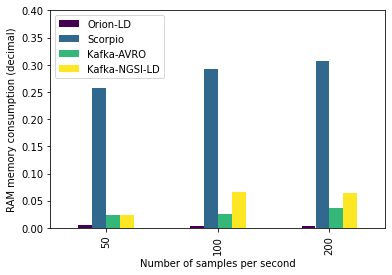

In [72]:
mem = pd.DataFrame({"Orion-LD": orion_mem_total,
                    "Scorpio": scorpio_mem_total,
                    "Kafka-AVRO": kafka_avro_mem_total,
                    "Kafka-NGSI-LD": kafka_ngsi_ld_mem_total}, index=events)
#colors = ['tab:blue','tab:orange', "tab:green", "tab:red"]
colors=cm.get_cmap('viridis', 4).colors
mem_plot = mem.iloc[[0,1,2]].plot.bar(logy=False, ylim=(0,0.4), color=colors)
mem_plot.set_xlabel("Number of samples per second")
mem_plot.set_ylabel("RAM memory consumption (decimal)")

mem.iloc[[0,1,2]]

,Orion-LD,Scorpio,Kafka-AVRO,Kafka-NGSI-LD
200,0.0042,0.3067,0.0371,0.0636


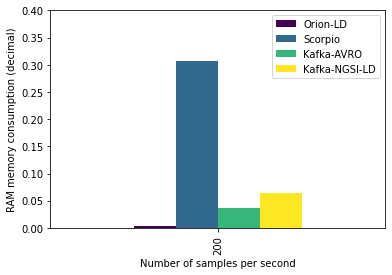

In [71]:
mem = pd.DataFrame({"Orion-LD": orion_mem_total,
                    "Scorpio": scorpio_mem_total,
                    "Kafka-AVRO": kafka_avro_mem_total,
                    "Kafka-NGSI-LD": kafka_ngsi_ld_mem_total}, index=events)
#colors = ['tab:blue','tab:orange', "tab:green", "tab:red"]
colors=cm.get_cmap('viridis', 4).colors
mem_plot = mem.iloc[[2]].plot.bar(logy=False, ylim=(0,0.4), color=colors)
mem_plot.set_xlabel("Number of samples per second")
mem_plot.set_ylabel("RAM memory consumption (decimal)")

mem.iloc[[2]]